# Домашнее задание 2 по обработке текстов

Рассмотрим задачу бинарной классификации. Пусть дано два списка имен: мужские и женские имена. Требуется разработать классификатор, который по данному имени будет определять мужское оно или женское.

Данные: 
* Женские имена: female.txt
* Мужские имена: male.txt

In [25]:
import re
import path
import nltk
import pymorphy2 
import pymystem3
import codecs
import numpy as np
import gensim
import pandas as pd
import matplotlib.pyplot as plt
import bokeh
import seaborn as sns
import random
from pylab import pcolor, show, colorbar, xticks, yticks

%matplotlib inline

In [2]:
males = pd.read_csv('male.txt', header=None)
males.rename(columns={0 : 'Name'}, inplace=True)
males.head(3)

,Name
0,Aamir
1,Aaron
2,Abbey


In [3]:
males.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2943 entries, 0 to 2942
Data columns (total 1 columns):
Name    2943 non-null object
dtypes: object(1)
memory usage: 23.1+ KB


In [4]:
females = pd.read_csv('female.txt', header=None)
females.rename(columns={0 : 'Name'}, inplace=True)
females.head(3)

,Name
0,Abagael
1,Abagail
2,Abbe


In [5]:
females.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 1 columns):
Name    5001 non-null object
dtypes: object(1)
memory usage: 39.1+ KB


## Часть 1. Предварительная обработка данных

1. Удалите неоднозначные имена (те имена, которые являются и мужскими, и женскими дновременно), если такие есть; 
2. Создайте обучающее и тестовое множество так, чтобы в обучающем множестве классы были сбалансированы, т.е. к классу принадлежало бы одинаковое количество имен;

In [6]:
common_names = pd.merge(males, females, on='Name', how='inner')
common_names.Name.count()

365

In [7]:
common_names['If_common'] = '1'

In [8]:
males_only = pd.merge(males, common_names, on='Name', how='left')
females_only = pd.merge(females, common_names, on='Name', how='left')

In [9]:
males_only = males_only[ pd.isna( males_only['If_common'] ) == 1 ]
females_only = females_only[ pd.isna( females_only['If_common'] ) == 1 ]

males_only.drop(columns='If_common', inplace=True)
males_only['Cat'] = 1
females_only.drop(columns='If_common', inplace=True)
females_only['Cat'] = 0

In [10]:
males_only = males_only.sample(frac=1).reset_index(drop=True)
females_only = females_only.sample(frac=1).reset_index(drop=True)

In [11]:
males_only.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2578 entries, 0 to 2577
Data columns (total 2 columns):
Name    2578 non-null object
Cat     2578 non-null int64
dtypes: int64(1), object(1)
memory usage: 40.4+ KB


In [12]:
females_only.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4636 entries, 0 to 4635
Data columns (total 2 columns):
Name    4636 non-null object
Cat     4636 non-null int64
dtypes: int64(1), object(1)
memory usage: 72.5+ KB


In [13]:
split_rate = int(0.9 * males_only.Cat.count())
print(split_rate)

2320


In [14]:
males_train = males_only[:2320]
females_train = females_only[:2320]
males_test = males_only[2321:]
females_test = females_only[2321:]

In [15]:
data_train = pd.concat([males_train, females_train])
data_test = pd.concat([males_test, females_test])

In [16]:
data_train = data_train.sample(frac=1).reset_index(drop=True)
data_test = data_test.sample(frac=1).reset_index(drop=True)

In [17]:
X_train = data_train['Name']
y_train = data_train['Cat']
X_test = data_test['Name']
y_test = data_test['Cat']

In [18]:
y_train.value_counts(normalize=True)

1    0.5
0    0.5
Name: Cat, dtype: float64

In [36]:
y_test.value_counts(normalize=True)

0    0.900078
1    0.099922
Name: Cat, dtype: float64

##  Часть 2. Базовый метод классификации

Используйте метод наивного Байеса или логистическую регрессию для классификации имен: в качестве признаков используйте символьные $n$-граммы. Сравните результаты, получаемые при разных $n=2,3,4$ по $F$-мере и аккуратности. В каких случаях метод ошибается?


In [27]:
X_train_list = (pd.Series(X_train)).tolist()
X_test_list =  (pd.Series(X_test)).tolist()

In [21]:
import random
random.seed(2904)
from sklearn.feature_extraction.text import *
from sklearn.metrics import *
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

###### Наивный Байес

In [45]:
# Для n=2

In [28]:
count_vect = CountVectorizer(analyzer='char', ngram_range=(2,2))
X_train_counts = count_vect.fit_transform(X_train_list)
X_train_counts.shape

(4640, 452)

In [29]:
clf = MultinomialNB().fit(X_train_counts, y_train)

In [32]:
X_test_counts = count_vect.transform(X_test_list)
predictions = clf.predict(X_test_counts)

Precision:   0.62
Recall:   0.76
F1-measure:   0.63
Accuracy:   0.78
             precision    recall  f1-score   support

          0       0.96      0.79      0.87      2315
          1       0.27      0.73      0.40       257

avg / total       0.89      0.78      0.82      2572



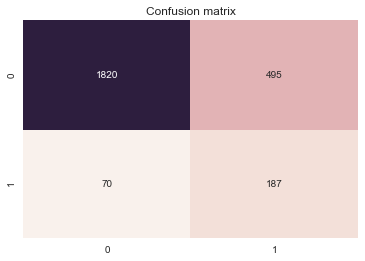

In [33]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))
labels = clf.classes_
sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [46]:
# Для n=3

In [37]:
count_vect = CountVectorizer(analyzer='char', ngram_range=(3,3))
X_train_counts = count_vect.fit_transform(X_train_list)
X_train_counts.shape

(4640, 2794)

In [38]:
clf = MultinomialNB().fit(X_train_counts, y_train)

In [39]:
X_test_counts = count_vect.transform(X_test_list)
predictions = clf.predict(X_test_counts)

Precision:   0.65
Recall:   0.79
F1-measure:   0.68
Accuracy:   0.83
             precision    recall  f1-score   support

          0       0.97      0.83      0.90      2315
          1       0.34      0.75      0.46       257

avg / total       0.91      0.83      0.85      2572



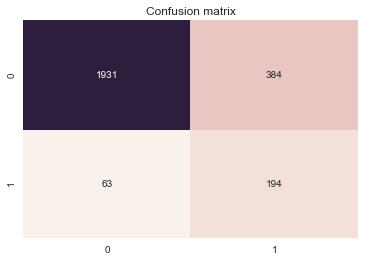

In [40]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))
labels = clf.classes_
sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [47]:
# Для n=4

In [41]:
count_vect = CountVectorizer(analyzer='char', ngram_range=(4,4))
X_train_counts = count_vect.fit_transform(X_train_list)
X_train_counts.shape

(4640, 6129)

In [42]:
clf = MultinomialNB().fit(X_train_counts, y_train)

In [43]:
X_test_counts = count_vect.transform(X_test_list)
predictions = clf.predict(X_test_counts)

Precision:   0.67
Recall:   0.78
F1-measure:   0.70
Accuracy:   0.85
             precision    recall  f1-score   support

          0       0.96      0.87      0.92      2315
          1       0.38      0.68      0.48       257

avg / total       0.90      0.85      0.87      2572



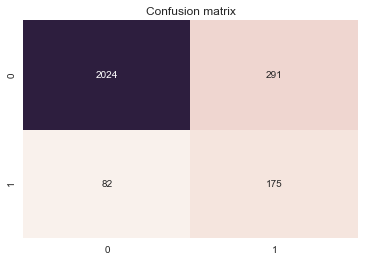

In [44]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))
labels = clf.classes_
sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

###### Логистическая регрессия

In [48]:
# Для n=2

In [49]:
count_vect = CountVectorizer(analyzer='char', ngram_range=(2,2))
X_train_counts = count_vect.fit_transform(X_train_list)
X_train_counts.shape

(4640, 452)

In [50]:
clf = LogisticRegression().fit(X_train_counts, y_train)
X_test_counts = count_vect.transform(X_test_list)
predictions = clf.predict(X_test_counts)

Precision:   0.66
Recall:   0.82
F1-measure:   0.69
Accuracy:   0.82
             precision    recall  f1-score   support

          0       0.98      0.82      0.89      2315
          1       0.34      0.82      0.48       257

avg / total       0.91      0.82      0.85      2572



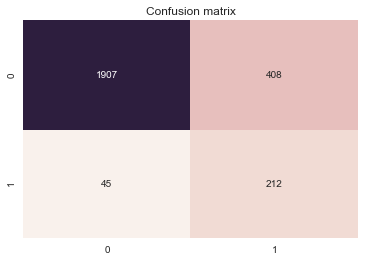

In [51]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))
labels = clf.classes_
sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [52]:
# Для n=3

In [53]:
count_vect = CountVectorizer(analyzer='char', ngram_range=(3,3))
X_train_counts = count_vect.fit_transform(X_train_list)
X_train_counts.shape

(4640, 2794)

In [54]:
clf = LogisticRegression().fit(X_train_counts, y_train)
X_test_counts = count_vect.transform(X_test_list)
predictions = clf.predict(X_test_counts)

Precision:   0.66
Recall:   0.83
F1-measure:   0.69
Accuracy:   0.82
             precision    recall  f1-score   support

          0       0.98      0.82      0.89      2315
          1       0.34      0.85      0.48       257

avg / total       0.92      0.82      0.85      2572



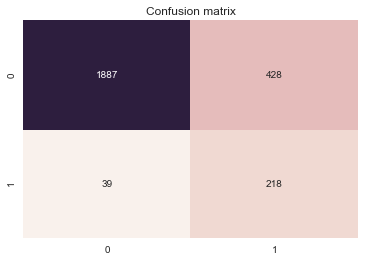

In [55]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))
labels = clf.classes_
sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [ ]:
#### Для n=4

In [56]:
count_vect = CountVectorizer(analyzer='char', ngram_range=(4,4))
X_train_counts = count_vect.fit_transform(X_train_list)
X_train_counts.shape

(4640, 6129)

In [57]:
clf = LogisticRegression().fit(X_train_counts, y_train)
X_test_counts = count_vect.transform(X_test_list)
predictions = clf.predict(X_test_counts)

Precision:   0.61
Recall:   0.79
F1-measure:   0.60
Accuracy:   0.73
             precision    recall  f1-score   support

          0       0.98      0.71      0.82      2315
          1       0.25      0.86      0.39       257

avg / total       0.91      0.73      0.78      2572



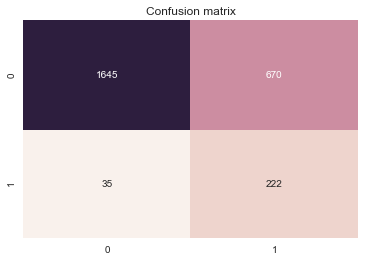

In [58]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))
labels = clf.classes_
sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

##  Часть 3. Нейронная сеть


Используйте  реккурентную нейронную сеть с  LSTM для решения задачи. В ней может быть несколько слоев с LSTM, несколько слоев c Bidirectional(LSTM).  У нейронной сети один выход, определяющий класс имени. 

Представление имени для классификации в этом случае: бинарная матрица размера (количество букв в алфавите $\times$ максимальная длина имени). Обозначим его через $x$. Если первая буква имени a, то $x[1][1] = 1$, если вторая – b, то  $x[2][1] = 1$.  

Не забудьте про регуляризацию нейронной сети дропаутами. 

Сравните результаты классификации разными методами. Какой метод лучше и почему?

Сравните результаты, получаемые при разных значениях дропаута, разных числах узлов на слоях нейронной сети по $F$-мере и аккуратности. В каких случаях нейронная сеть ошибается?

Если совсем не получается запрограммировать нейронную сеть самостоятельно, обратитесь к туториалу тут: https://github.com/divamgupta/lstm-gender-predictor